# ✨ Aplicação do Python para tratamento de dados do setor elétrico

## O que iremos aprender?

0. Por quê aprender?

1. Coletar arquivos do modelo de previsão GEFS, direto da fonte;
2. Como trabalhar com a extensão grib;
3. Visualização espacial da previsão;
4. Manipulação da informação na grade;
5. Granularização! - Breve estudo sobre a previsão na bacia de Itaipu

## Um pouquinho sobre o GEFS...

### GEFS

Segundo a [documentação](https://github.com/awslabs/open-data-docs/tree/main/docs/noaa/noaa-gefs-pds) do modelo, o GEFS é um modelo de previsão com 21 membros separados e o ensemble destes. 

Os arquivos de previsão do GEFS são no formato grib2, e estão armazenados no [bucket s3](https://registry.opendata.aws/noaa-gefs/) `noaa-gefs-pds`, na AWS.

### Informações gerais

- O GEFS possui previsões de 6 em 6 horas, até a hora 384;
- Os ciclos disponíveis são 00, 06, 12 e 18;
- O arquivo **controle** possui o prefixo `gec00`;
- Os demais membros possuem o prefixo `gep<ix>`, onde `<ix>` deve ser substituído pelo número do membro, de 01 a 20.
- O modelo possui duas resoluções disponíveis, [0.25x0.25](https://noaa-gefs-pds.s3.amazonaws.com/index.html#gefs.20211116/00/atmos/pgrb2sp25/) ou [0.5x0.5](https://noaa-gefs-pds.s3.amazonaws.com/index.html#gefs.20211116/00/atmos/pgrb2bp5/). No entanto, o modelo com a maior resolução possui um número mais limitado de variáveis.
> [Variáveis em resolução 0.5](https://www.nco.ncep.noaa.gov/pmb/products/gens/gec00.t00z.pgrb2b.0p50.f000.shtml) x [Variáveis em resolução 0.25](https://www.nco.ncep.noaa.gov/pmb/products/gens/gec00.t00z.pgrb2s.0p25.f000.shtml)

## Importando as bibliotecas

In [1]:
import cartopy.crs as ccrs
import geopandas as gpd
import numpy as np
import boto3
import os
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import rioxarray as rio

from datetime import date
from typing import List
from pathlib import Path

In [2]:
def formatar_ds64(ds64: np.datetime64, formato: str = '%d/%m/%Y %H:%M') -> str:
    """
    Formata um objeto np.datetime64 para uma string de data.
    
    Parameters
    ----------
    ds64 : np.datetime64
        Objeto de data numpy.
        
    formato : str
        Formato da data de saída.
        
    Returns
    -------
    str
        Data formatada.
    """
    ts = pd.to_datetime(str(ds64)) 
    d = ts.strftime(formato)
    return d

def abrir(grib: Path, variavel: str, tipo: str = 'isobaricInhPa') -> xr.Dataset:
    """
    Abre um arquivo grib.
    
    Parameters
    ----------
    grib : Path
        Caminho para o arquivo grib.
        
    tipo : str
        Tipo de nível avaliado. 
        Ver parâmetro typeOfLevel do cfgrib.
        
    variavel : str
        Nome da variável.
        Ver parâmetro shortName do cfgrib.
        
    Returns
    -------
    xr.Dataset
        Dataset legível do grib.
    """
    return xr.open_dataset(
        grib,
        engine='cfgrib',                   
        backend_kwargs={
            "filter_by_keys": {
                'typeOfLevel': tipo,
                'shortName': variavel
                },
        },
    )


def exportar_netcdf(ds: xr.Dataset, dir_saida: Path) -> None:
    """
    Exporta um dataset para o formato netcdf.
    
    Parameters
    ----------
    ds : xr.Dataset
        Dataset a ser exportado.
        
    dir_saida : Path
        Caminho para o arquivo exportado.
    """
    ds.to_netcdf(dir_saida)
    
    
def listar_diretorio(diretorio: Path, padrao: str = '*') -> List[Path]:
    """
    Lista todos os arquivos com uma extensão em um diretório.
    
    Parameters
    ----------
    diretorio : Path
        Diretório onde estão localizados os arquivos.
        
    padrao : str
        Padrao de nome para a coleta. Exemplo: '*.txt'
    
    Returns
    -------
    List[Path]
        Lista de caminhos para os arquivos que possuem a extensão
        solicitada dentro do diretório.
    """
    return list(diretorio.glob(f"{padrao}"))


def concatenar_netcdfs(datasets: List[Path]) -> xr.Dataset:
    """
    Concatena uma lista de arquivos netcdf.
    
    Parameters
    ----------
    datasets : List[Path]
        Lista de caminhos para os arquivos netcdf.
        
    Returns
    -------
    xr.Dataset
        Dataset concatenado.
    """
    return xr.open_mfdataset(datasets, combine='nested', concat_dim='valid_time').sortby('valid_time')

def padronizar_coordenadas(
    ds: xr.Dataset, 
    xdim: str = "longitude", 
) -> xr.Dataset:
    """
    Converte a longitude do dataset para os limites entre -180 e 180.
    
    Parameters
    ----------
    ds: xr.Dataset
        Dataset a ser ajustado.
        
    xdim: str
        Nome da dimensão x.
    
    Returns
    -------
    xr.Dataset
        Dataset com a dimensão de longitude convertida.
    """
    ds = ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180)).sortby(xdim)
    return ds

def definir_crs(
    ds: xr.Dataset, 
    crs: str = "epsg:4326", 
    xdim: str = "longitude", 
    ydim: str ="latitude"
) -> xr.Dataset:
    """
    Define o sistema de coordenadas de um dataset.
    
    Parameters
    ----------
    ds: xr.Dataset
        Dataset a ser projetado.
        
    crs: str
        Sistema de coordenadas a ser utilizado.
    
    xdim: str
        Nome da dimensão x.
    
    ydim: str
        Nome da dimensão y.
    
    Returns
    -------
    xr.Dataset
        Dataset projetado no crs.
    """
    ds = ds.rio.set_spatial_dims(x_dim=xdim, y_dim=ydim) 
    ds = ds.rio.write_crs(crs)
    return ds

## Configurações gerais do projeto

Neste ponto, iremos declarar no código o que desejamos coletar. Data de partida da previsão, ciclo, membro, algumas configurações básicas próprias do modelo e que constam na documentação... Coisas do tipo.

#### Setando a data de coleta dos dados de previsão do GEFS

In [3]:
hoje = date.today()
hoje_fmt = hoje.strftime("%Y%m%d")

#### Setando informações básicas sobre o produto coletado

In [4]:
bucket = 'noaa-gefs-pds'

ciclo = '00'
n_max_passos = 384 # previsão mais distante temporalmente para os arquivos do tipo a
passo_tempo = 6 # incremento do passo no tempo
passos = np.arange(0, n_max_passos + passo_tempo, passo_tempo) # incrementando +1 passo tempo porque o arange é fechado à direita
membro = 'gec00' # GEFS controle
resolucao = '50' # 25 (.25x.25) ou 50 (.5x.5)
tipo_dado = 'a'

crs = 'epsg:4326' # Sistema de referência WGS84

#### Setando os diretórios de armazenamento dos arquivos do GEFS

In [5]:
dir_tmp = Path(".", hoje_fmt, ciclo, membro)
dir_tmp.mkdir(exist_ok=True, parents=True)

dir_grib = dir_tmp.joinpath("grib")
dir_nc = dir_tmp.joinpath("nc")

dir_grib.mkdir(exist_ok=True, parents=True)
dir_nc.mkdir(exist_ok=True, parents=True)

### Download dos dados do modelo

In [6]:
s3 = boto3.client('s3')

In [7]:
arquivos = list()
for passo in passos:
    passo_fmt = str(passo).zfill(3)
    nome_grib = f'{membro}.t{ciclo}z.pgrb2{tipo_dado}.0p{resolucao}.f{passo_fmt}'
    prefixo = f'gefs.{hoje_fmt}/{ciclo}/atmos/pgrb2ap5/{nome_grib}'
    
    arquivo_grib_local = dir_grib.joinpath(nome_grib)
    
    with open(arquivo_grib_local, 'wb') as arquivo:
        s3.download_fileobj(bucket, prefixo, arquivo)        

In [8]:
exemplo = abrir(arquivo_grib_local, variavel='tp', tipo='surface')

### Conversão do grib para netcdf

Iremos converter o formato do arquivo para netcdf, que é bem mais fácil de trabalhar. O processo será: 
1. Abrir o grib
2. Exportá-lo para netcdf (assim, podemos armazenar o dado já nesse formato)
3. EXTRA: remover o grib, só para salvar um pouco de espaço :)

Para otimizar o loop, como é um caso de estudo e exemplificação, aqui já estamos recortando as variáveis que desejamos do nosso grib. Neste caso, será a precipitação total acumulada em períodos de 6 em 6 horas.

In [9]:
gribs = listar_diretorio(dir_grib, padrao='*[!idx]')

In [10]:
variaveis = ['tp']
tipo = 'surface'

for grib in gribs:
    for variavel in variaveis:
        try:
            ds = abrir(grib, variavel=variavel, tipo=tipo)
            nome_grib = os.path.basename(grib)
            nome_nc = f'{str(nome_grib).replace(".", "_")}_{variavel}.nc'

            arquivo_nc_local = dir_nc.joinpath(nome_nc)
            exportar_netcdf(ds, dir_saida=arquivo_nc_local)
        except (KeyError):
            print(
                f'Variável indisponível no arquivo {grib}'
            )
    
    os.remove(grib)

Variável indisponível no arquivo 20211121/00/gec00/grib/gec00.t00z.pgrb2a.0p50.f000


### Concatenação dos arquivos netcdf

Os arquivos neste ponto estão todos listados em um diretório de arquivos netcdf, cada arquivo representando um passo de tempo. O ideal será concatenar todos esses arquivos em apenas um, a nível de organização e maleabilidade do produto.

In [11]:
arquivos_netcdf = listar_diretorio(dir_nc)
ds = concatenar_netcdfs(arquivos_netcdf)
ds = ds.drop(["number", "time", "surface", "step"])
ds_america_sul = ds.sel(latitude=slice(10, -60)).sel(longitude=slice(270, 340))
ds_carregado = ds_america_sul.load() # removendo chunks do dask

In [12]:
ds_carregado

<xarray.Dataset>
Dimensions:     (latitude: 141, longitude: 141, valid_time: 64)
Coordinates:
  * latitude    (latitude) float64 10.0 9.5 9.0 8.5 ... -58.5 -59.0 -59.5 -60.0
  * longitude   (longitude) float64 270.0 270.5 271.0 ... 339.0 339.5 340.0
  * valid_time  (valid_time) datetime64[ns] 2021-11-21T06:00:00 ... 2021-12-07
Data variables:
    tp          (valid_time, latitude, longitude) float32 1.43 1.16 ... 0.0 0.0
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          2
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    history:                 2021-11-21T20:03 GRIB to CDM+CF via cfgrib-0.9.9...

### Plot da previsão de precipitação acumulada pelo GEFS

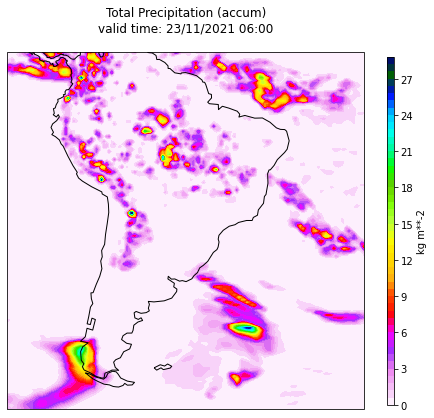

In [13]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})

acumulado = ds_carregado.isel(valid_time=8).tp
x = acumulado.longitude
y = acumulado.latitude
z = acumulado.values

data = acumulado.valid_time.values
data_fmt = formatar_ds64(data)

contorno = ax.contourf(x, y, z, 50, cmap='gist_ncar_r')
cbar = fig.colorbar(
    contorno,
    extendfrac='auto',
    spacing='uniform',
    shrink=0.8,
    aspect=50
)

cbar.set_label(f'{ds_carregado.tp.units}')
ax.set_title(f'{ds_carregado.tp.long_name} ({ds_carregado.tp.GRIB_stepType})\nvalid time: {data_fmt}\n')

ax.coastlines()

### Previsão para uma bacia

Podemos granularizar a nossa análise e verificar qual é a previsão de precipitação do modelo para apenas o contorno de uma bacia. Neste caso, escolheremos a bacia de Itaipu.

#### Alterando o acumulado de 6h para 24h e 72h

Também poderíamos somar os acumulados para completarmos 24h. Assim, ao invés do acumulado para as próximas 6h, poderíamos descobrir o acumulado para as próximas 24h, 48h, 72h, e assim por diante... e temos um ganho muito grande sobre a manipulação do dado!

In [14]:
acumulado_24 = ds_carregado.resample(valid_time="24H", closed='right').sum()

In [15]:
ds_carregado

<xarray.Dataset>
Dimensions:     (latitude: 141, longitude: 141, valid_time: 64)
Coordinates:
  * latitude    (latitude) float64 10.0 9.5 9.0 8.5 ... -58.5 -59.0 -59.5 -60.0
  * longitude   (longitude) float64 270.0 270.5 271.0 ... 339.0 339.5 340.0
  * valid_time  (valid_time) datetime64[ns] 2021-11-21T06:00:00 ... 2021-12-07
Data variables:
    tp          (valid_time, latitude, longitude) float32 1.43 1.16 ... 0.0 0.0
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          2
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    history:                 2021-11-21T20:03 GRIB to CDM+CF via cfgrib-0.9.9...

In [16]:
acumulado_24

<xarray.Dataset>
Dimensions:     (valid_time: 16, latitude: 141, longitude: 141)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2021-11-21 2021-11-22 ... 2021-12-06
  * latitude    (latitude) float64 10.0 9.5 9.0 8.5 ... -58.5 -59.0 -59.5 -60.0
  * longitude   (longitude) float64 270.0 270.5 271.0 ... 339.0 339.5 340.0
Data variables:
    tp          (valid_time, latitude, longitude) float32 3.93 3.26 ... 0.7 0.9

In [17]:
shp = Path("contornos", "itaipu.shp")
gdf = gpd.read_file(shp)
gdf.set_crs(crs, inplace=True)

,bacia,geometry
0,Itaipú,"POLYGON ((-55.62486 -22.62734, -55.62492 -22.6..."


In [18]:
acumulado_24 = padronizar_coordenadas(acumulado_24)
acumulado_24 = definir_crs(acumulado_24, crs=crs)

In [19]:
recorte_bacia = acumulado_24.rio.clip(gdf.geometry, gdf.crs,)

<GeoAxesSubplot:title={'center':'valid_time = 2021-11-29, spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

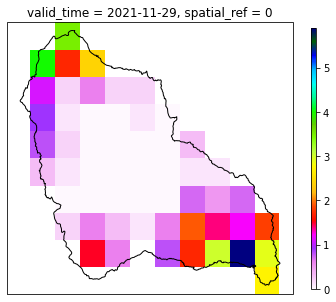

In [20]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})

contorno = recorte_bacia.isel(valid_time=8).tp
cs = contorno.plot(ax=ax, cmap='gist_ncar_r')
cbar = fig.colorbar(
    cs,
    extendfrac='auto',
    spacing='uniform',
    shrink=0.6,
    aspect=50,
    ax=ax,
)

# remove a barra de cores default
fig.axes[1].remove()

gdf.geometry.plot(ax=ax, facecolor='none', edgecolor='k')

In [21]:
media_regional = recorte_bacia.mean(dim=["latitude", "longitude"])
media_regional = media_regional.drop(["spatial_ref"])

In [161]:
media_regional

<xarray.Dataset>
Dimensions:     (valid_time: 16)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2021-11-19 2021-11-20 ... 2021-12-04
Data variables:
    tp          (valid_time) float32 1.527 0.2564 0.02727 ... 0.002545 0.02491

In [162]:
df = media_regional.to_dataframe()

In [164]:
df

,tp
valid_time,
2021-11-19,1.527273
2021-11-20,0.256364
2021-11-21,0.027273
2021-11-22,0.000000
2021-11-23,0.000000
2021-11-24,0.000000
2021-11-25,0.587818
2021-11-26,9.152727
2021-11-27,33.600548


Text(0.5, 1.0, 'Total Precipitation (accum)\nItaipú\n')

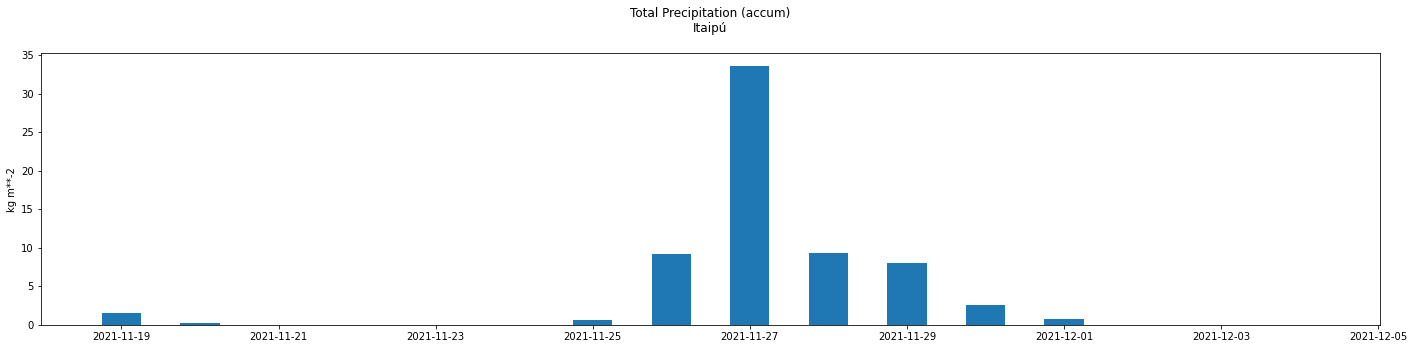

In [146]:
fig, ax = plt.subplots(figsize=(24, 5))

ax.bar(x=df.index, height=df.tp, width=0.5)
ax.set_ylabel(f'{ds_carregado.tp.units}')
ax.set_title(f'{ds_carregado.tp.long_name} ({ds_carregado.tp.GRIB_stepType})\n{gdf.bacia[0]}\n')

# Obrigada!

#### meu email: andradelis@id.uff.br